In [1]:
import toml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from toolz import partial
from tqdm.auto import tqdm
from rl_analysis import ANALYSIS_CONFIG
from rl_analysis.behavior.moseq import add_onset_and_duration
from rl_analysis.plotting import save_factory, setup_plotting_env, fg, clean_ticks, syllable_aliases

In [3]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'fig-s09'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300

In [4]:
df = pd.read_parquet(
    join(config["raw_data"]["closed_loop_behavior"], "closed_loop_behavior.parquet"),
    columns=[
        "predicted_syllable",
        "target_syllable",
        "session_number",
        "uuid",
        "feedback_status",
        "area",
        "stim_duration",
        "mouse_id",
    ],
)

In [5]:
df = df[(~df["session_number"].isin([1, 2])) & df["area"].isin(["ctrl", "snc (axon)"])].copy()
df = add_onset_and_duration(df)

In [6]:
durs = (
    df[df["onset"]].set_index(["mouse_id", "predicted_syllable"])["dur"].sort_index()
) / 30

In [7]:
stats = durs.groupby('predicted_syllable').agg(['mean', 'median', pd.Series.mode])

In [8]:
stats.head()

,mean,median,mode
predicted_syllable,,,
4,1.086025,0.566667,0.300000
5,0.802040,0.533333,0.266667
7,0.358527,0.300000,0.266667
8,0.377581,0.300000,0.266667
10,0.254236,0.233333,0.066667


In [9]:
stats.loc[[17, 20, 27, 30, 59, 76]]

,mean,median,mode
predicted_syllable,,,
17,0.408280,0.333333,0.266667
20,0.495718,0.400000,0.300000
27,0.928566,0.600000,0.266667
30,0.452924,0.366667,0.266667
59,0.564042,0.433333,0.266667
76,0.370967,0.333333,0.266667


In [10]:
xlims = (0, 2.5)

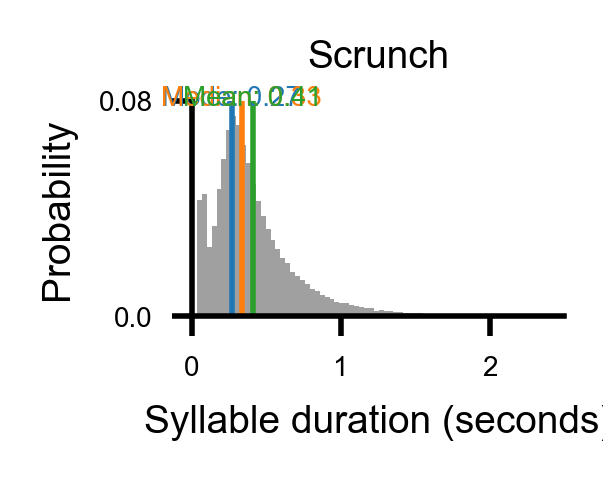

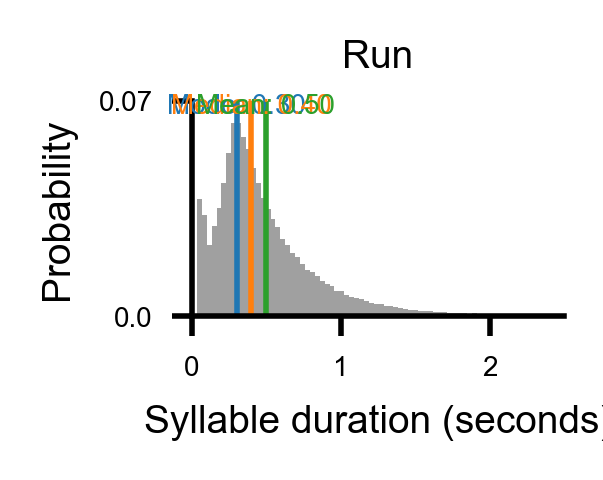

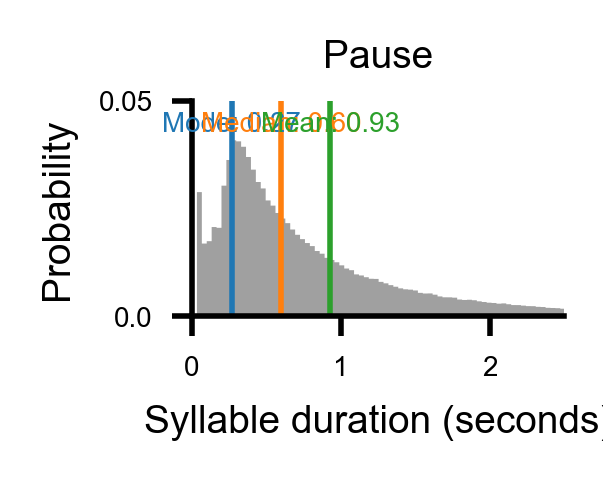

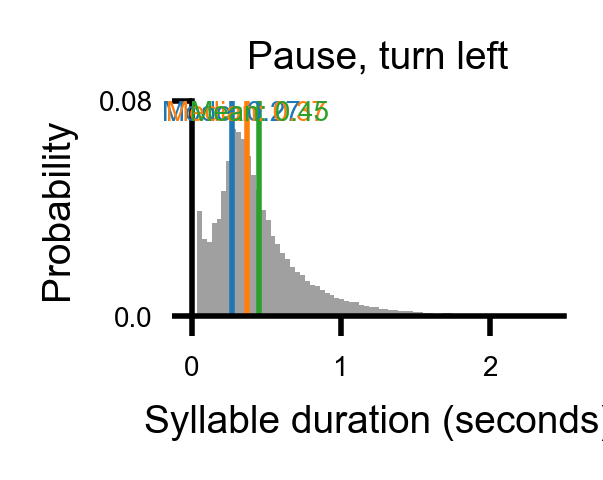

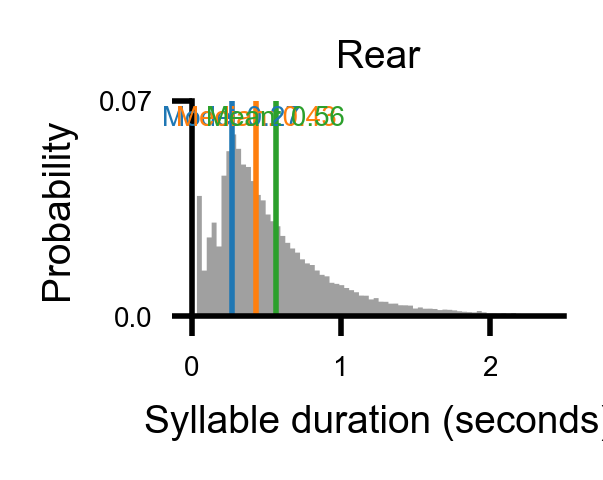

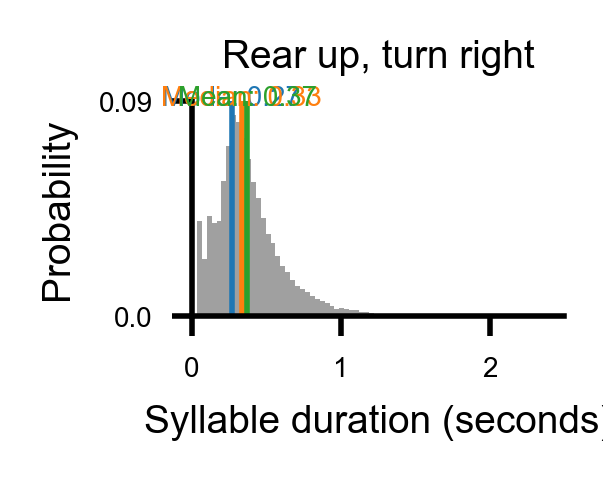

In [12]:
for syll in [17, 20, 27, 30, 59, 76]:
    fig = fg(1.2, 0.7)
    fig.dpi = 200
    ax = sns.histplot(
        durs.loc[pd.IndexSlice[:, syll]],
        binwidth=0.033,
        element="step",
        color="gray",
        linewidth=0,
        stat="probability",
    )
    _, top = plt.ylim()
    for i, k in enumerate(("mode", "median", "mean")):
        x = stats.loc[syll, k]
        plt.axvline(x, color=f'C{i}')
        plt.text(x, top, f"{k.capitalize()}: {x:0.2f}", ha="center", fontsize=5, color=f'C{i}')
    plt.xlim(xlims)
    plt.xlabel("Syllable duration (seconds)")
    plt.title(syllable_aliases[syll], fontsize=7)
    clean_ticks(ax, axis="y", zero_symmetry=False)
    sns.despine()
    saver(fig, f"syll-{syll}-duration-distribution")